Now I need to go through my cleaned word list, split all sentences into their individual words, and create a new dataframe containing each individual word and the number of occurrences within the dataset to determine dataset word frequency (Which I will take as a proxy for overall word frequency). This isn't perfect and will ignore context-defined meaning in words that are spelled the same, as this will be counted as only one highly frequent word with multiple meanings rather than several less-frequent words that are spelled the same.

A few issues will need to be solved here.

1. There will be typos and misspellings in the dataset which as well as being less useful as a learning tool, will also lead to some words (particularly those with accents that have been forgotten or misplaced) being counted multiple times, so they'll somehow need to be joined together. I can't just remove all accents as this can change the meaning of a word entirely (côté vs. côte). I might have to reduce the number of sentences in the active dataset and spell check them more thoroughly with grammarly or some other tool.

2. Words that have been shortened due to consecutive vowels (l, d etc. could have multiple meanings such as le or la, or de or du), but since these are incredibly common words that will always have high scores it might not be so much of an issue for gauging the word's frequency. I just need to make sure to check less frequent words that have been shortened i.e. the presque in presqu'île, although I imagine this shortening would be sufficiently infrequent relative to its unshortened form as to have almost no bearing on its frequency score.

3. I might have to set some custom rules for when to keep an apostrophe. Returning to my previous example, presqu'île should really be treated as a single word, and other such exceptions will exist. I just need to go down the frequency list and note them down.

4. Different word types will have differing numbers of forms. Adjectives can be masculine or feminine (public, publique), plus others such as publiquement. Verbs can have a very large number of forms, meaning etre is likely to be separated far more than most adjectives which will have fewer forms, which could lead to forms of etre appearing below far less common words in the frequency list. For a language learner these forms can sometimes be similar in form, allowing a transfer of knowledge when learning new forms (If they know courir it doesn't take much to figure out that couru is just the past tense), while other times the different forms might represent entirely new strings of characters that must all be learnt independently from one another (aller, irai etc.). I'd say that since these are effectively different words that each have to be learned, it is reasonable that they are treated separately. I'm effectively mapping the frequency of different strings of letters appearing in a language.

Solution:

Overall, while this method for measuring word frequency is flawed in multiple ways, as long as I ensure that the sentences in my database are grammatically correct it should be useful enough as a tool to gauge sentence complexity via average word frequency, which is the ultimate aim. I could also use POS tagging by running each sentence through a pretrained hidden markov model or something similar to label word type, and have the frequency for each word+type pair. This would avoid the issue of words with multiple meanings being classified together (est for is and east etc.). I have to do this later for the single-word translation to work so it would make sense to do it now.

In [90]:
import re
import pandas as pd
from collections import defaultdict
import constants

In [91]:
filepath = f"../output_files/{constants.language_code}/step3_sentences.csv"

df = pd.read_csv(filepath, delimiter='\t')

In [92]:
df.count()

id          407280
sentence    407280
dtype: int64

In [93]:
# Create regex

fr_exceptions = [
    "[Aa]ujourd'hui",
    "[Pp]resqu'île",
    "[Qq]uelqu'un",
    "[Dd]'accord"
    ]

de_exceptions = []

exceptions = {
    'fr': fr_exceptions,
    'de': de_exceptions
    }[constants.language_code]

word_regex = {
    'fr': r'[a-zA-ZéèêëÉÈÊËàâäÀÂÄôöÔÖûüÛÜçÇîÎïÏ]+',
    'de': r'[a-zA-ZäöüÄÖÜß]+'
    }[constants.language_code]

exceptions_regex = '|'.join(exceptions)

regex = fr'\b{exceptions_regex}|{word_regex}\b'

In [94]:
shortened_word_map = {
    'j': 'je',
    #'l': 'le', # Can be either so will handle after to speed up function
    't': 'tu', # This will assign the t in a-t-on to tu for example, which will give tu a higher frequency than it should have, but it's only one very common word so I'm not going to address it
    'd': 'de', # Need to check whether this is ever du
    'c': 'ce',
    's': 'se',
    'qu': 'que',
    'm': 'me',
    'n': 'ne',
    }

def scan_sentence(sentence: str, unique_word_counts: defaultdict) -> defaultdict:
    '''Scans a sentence to get its words and updates the unique word count dictionary.
    Local unique_word_counts points to global variable so can update directly. The use
    of a default dict means we don't have to check if a key is in the dictionary before
    adding it as it will initialise to 1.

    Using a dict instead of a dataframe means there's O(1) time complexity for insertions
    and lookups, and using a defaultdict to avoid an additional check means this runs
    incredibly quickly on even very large datasets.
    '''

    # Split all words in the sentence by word boundaries (Split uninclusively at punctuation or non-alphanumeric characters)
    words = re.findall(regex, sentence) # Words only

    # Set all words to lowercase
    words = [word.lower() for word in words]

    # Replace any shortened words with their full-length version
    words = [shortened_word_map.get(word, word) for word in words]

    for word in words:

        # Add 1 to count. If word doesn't exist adds in new entry
        unique_word_counts[word] += 1

    return unique_word_counts

In [95]:
#unique_word_counts = pd.DataFrame(columns=['word', 'count'])
unique_word_counts_dict = defaultdict(int)

for sentence in df['sentence'].values:

    #unique_word_counts = scan_sentence(sentence, unique_word_counts)
    unique_word_counts_dict = scan_sentence(sentence, unique_word_counts_dict)

# Convert the dictionary to a list of tuples
unique_word_counts = list(unique_word_counts_dict.items())

# Convert the list to a DataFrame
unique_word_counts = pd.DataFrame(unique_word_counts, columns=['word', 'count'])

In [96]:
# Need to distribute l appropriately between le and la counts. Based off my previous counts la occurs
# 55% of the time
if (constants.language_code == 'fr'):

    le_frequency = 0.45

    l_count = unique_word_counts[unique_word_counts['word'] == 'l']['count'].values[0]

    unique_word_counts.loc[unique_word_counts['word'] == 'le', 'count'] += l_count * le_frequency
    unique_word_counts.loc[unique_word_counts['word'] == 'la','count'] += l_count * (1 - le_frequency)

    # Remove l row
    unique_word_counts = unique_word_counts.drop(
        unique_word_counts[unique_word_counts['word'] == 'l'].index
        )

121906


C:\Users\Toby Usher\AppData\Local\Temp\ipykernel_17288\3181318139.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[233774.7]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  unique_word_counts.loc[unique_word_counts['word'] == 'le', 'count'] += l_count * le_frequency


In [97]:
'''
# A parallel approach to creating the unique word counts for when the dataset becomes too big to feasibly handle
# with a single python process

import numpy as np
import multiprocessing

# check how many cores are available
num_cpus = multiprocessing.cpu_count()

num_chunks = 4

if num_cpus < num_chunks:
    raise SystemError(f'Insufficient number of CPUs ({num_cpus}) for chosen number of chunks ({num_chunks})')

# split dataset into chunks
chunks = np.array_split(df, num_chunks)

# Define the function to be run in each process
def process_chunk(chunk):
    """Calculates the unique word counts for a given chunk of the sentences
    """

    unique_word_counts = pd.DataFrame(columns=['word', 'count'])

    # Perform your operations on the chunk here
    # For example, compute the mean of each column
    for sentence in chunk['sentence'].values:

        unique_word_counts = scan_sentence(sentence, unique_word_counts)

    return unique_word_counts

# Create a pool of processes
with multiprocessing.Pool(num_chunks) as p:
    # Apply the function to each chunk in the pool of processes
    results = p.map(process_chunk, chunks)

# Now 'results' is a list of the results from each process
for i, chunk_unique_word_counts in enumerate(results):
    pass
    # TODO: Combine the unique word count dataframes from each process into one and save

'''

'\n# A parallel approach to creating the unique word counts for when the dataset becomes too big to feasibly handle\n# with a single python process\n\nimport numpy as np\nimport multiprocessing\n\n# check how many cores are available\nnum_cpus = multiprocessing.cpu_count()\n\nnum_chunks = 4\n\nif num_cpus < num_chunks:\n    raise SystemError(f\'Insufficient number of CPUs ({num_cpus}) for chosen number of chunks ({num_chunks})\')\n\n# split dataset into chunks\nchunks = np.array_split(df, num_chunks)\n\n# Define the function to be run in each process\ndef process_chunk(chunk):\n    """Calculates the unique word counts for a given chunk of the sentences\n    """\n\n    unique_word_counts = pd.DataFrame(columns=[\'word\', \'count\'])\n\n    # Perform your operations on the chunk here\n    # For example, compute the mean of each column\n    for sentence in chunk[\'sentence\'].values:\n\n        unique_word_counts = scan_sentence(sentence, unique_word_counts)\n\n    return unique_word_coun

Having looked at the dataset, most words that appear three times or fewer in the dataset are either typos or
sufficiently obscure that I should probably remove any sentences that contain these words. The logarithmic
nature of word frequency distributions in a text corpus means this will cause the number of unique words in
the corpus to drop significantly

In [98]:
# The number of times a word has to appear in the corpus for it to be kept
obscurity_cutoff = 16

# Get list of words that occur less than this in the dataset
obscure_words = unique_word_counts[unique_word_counts['count'] < obscurity_cutoff]['word'].to_list()

# Convert the list of words to a set for faster lookup
obscure_words = set(obscure_words)

# Split the sentences into words (Must use the same regex as was used to create the original word frequency list)
df['words'] = df['sentence'].apply(lambda x: re.findall(regex, x.lower()))

# Remove any rows where the sentence contains one of the an obscure words
df = df[~df['words'].apply(lambda x: any(word in obscure_words for word in x))]

In [99]:
df.count()

id          173406
sentence    173406
words       173406
dtype: int64

This has removed around 200,000 sentences from the dataset and drastically reduced the number of unique words

In [100]:
df.head()

,id,sentence,words
0,3,La vierge du Seigneur sen alla ensuite termin...,"[la, vierge, du, seigneur, s, en, alla, ensuit..."
1,4,Présentation de celui-ci à plusieurs écoles pr...,"[présentation, de, celui, ci, à, plusieurs, éc..."
3,7,"Dès le 5 novembre, les syndicats avaient donc ...","[dès, le, novembre, les, syndicats, avaient, d..."
4,9,"S'il le faut, je serai devant vous, c'est clair ?","[s, il, le, faut, je, serai, devant, vous, c, ..."
9,26,Il a rejeté la demande déposée par le Comité A...,"[il, a, rejeté, la, demande, déposée, par, le,..."


In [101]:
# Remove the abscure words from the word counts dataframe and save new dataset and word counts
unique_word_counts = unique_word_counts[unique_word_counts['count'] >= obscurity_cutoff]

# Sort and save the frequency list into final tables
sorted_word_counts = unique_word_counts.sort_values(by='count', ascending=False)

# Reset index to be the frequency rank
sorted_word_counts['rank'] = sorted_word_counts['count'].rank(ascending=False)

sorted_word_counts = sorted_word_counts[['rank', 'word', 'count']]

sorted_word_counts.to_csv(f'../output_files/{constants.language_code}/step4_unique_word_counts.csv')

In [102]:
#import matplotlib.pyplot as plt

# Keep every 100th value for quicker plotting
#sorted_word_counts[sorted_word_counts['count'] > 1]['count'].plot(kind='bar')
#plt.show()


# Creating word frequency-based sentence complexity scores

Now we know all word frequencies, this information can be used to figure out the average sentence complexity of words within each sentence to get a preliminary idea of which sentences will be more difficult to understand / more or less useful for a language learner at any given level.

In [103]:
import numpy as np

# Use the original word counts dict (Still contains the obscure words but should still be quicker)
# to calculate the average and min word counts for each sentence

def calculate_average_and_min(row, word_counts):

    # Gets all counts for the sentence. Defaults to zero if word missing although this should
    # never happen
    counts = [word_counts.get(word, 0) for word in row]

    if not counts:
        return pd.Series([0, 0])
    
    return pd.Series([np.mean(counts), np.min(counts)])

# Mean of all word count frequencies, minimum word frequency (rarest word) in sentence
df[['average_count', 'min_count']] = df['words'].apply(calculate_average_and_min, args=(unique_word_counts_dict,))

C:\Users\Toby Usher\AppData\Local\Temp\ipykernel_17288\3641391163.py:18: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df[['average_count', 'min_count']] = df['words'].apply(calculate_average_and_min, args=(unique_word_counts_dict,))


In [104]:
# Create rank columns for average and min counts
df['average_count_rank'] = df['average_count'].rank(ascending=True)
df['min_count_rank'] = df['min_count'].rank(ascending=False)

In [105]:
if 'cluster' not in df.columns:
    df['cluster'] = 'cluster 0'

# Add in placeholder for translation for now
df['translated_sentence'] = 'Translation'

# Put the dataframe in the correct format for the Django model
df = df[[
    'sentence',
    'translated_sentence',
    'cluster',
    'words',
    'average_count',
    'min_count',
    'average_count_rank',
    'min_count_rank'
    ]]

In [111]:
ordered_df = df.sort_values(by='min_count', ascending=True)
ordered_df.to_csv(f'../output_files/{constants.language_code}/step4_sentences.csv')

# Experimentation

In [107]:
# Get only sentences whose words are all in the top 1000 most frequent words in the corpus
threshold_count = sorted_word_counts[
    (sorted_word_counts.index > 999.0) & (sorted_word_counts.index < 1001.0)
    ]['count'].values[0]

top_thousand_word_sentences = df[df['min_count'] >= threshold_count]

top_thousand_word_sentences.head(50)

,sentence,translated_sentence,cluster,words,average_count,min_count,average_count_rank,min_count_rank
556,Il est le même pour tout le monde.,Translation,cluster 0,"[il, est, le, même, pour, tout, le, monde]",74448.000000,5287.0,123216.0,5.0
3962,Est-ce que ce sera le cas cette année?,Translation,cluster 0,"[est, ce, que, ce, sera, le, cas, cette, année]",51577.111111,4265.0,72482.0,15.0
8643,"Français un jour, Français toujours ?",Translation,cluster 0,"[français, un, jour, français, toujours]",21254.400000,3612.0,9811.0,21.0
14466,Il ne peut pas y avoir de place pour tout le m...,Translation,cluster 0,"[il, ne, peut, pas, y, avoir, de, place, pour,...",74426.666667,5047.0,123173.0,7.0
56424,"Qui peut le plus, peut le moins.",Translation,cluster 0,"[qui, peut, le, plus, peut, le, moins]",65369.428571,5065.0,104070.0,6.0
63096,"Dans les 12 mois, dans les autres cas.",Translation,cluster 0,"[dans, les, mois, dans, les, autres, cas]",60983.142857,4265.0,94073.0,15.0
129409,Et cela depuis plusieurs années.,Translation,cluster 0,"[et, cela, depuis, plusieurs, années]",32297.800000,3741.0,27619.5,19.0
136863,Entre 7000 et 10000 dans tout le pays.,Translation,cluster 0,"[entre, et, dans, tout, le, pays]",67446.000000,5758.0,108551.0,3.5
166264,Ces personnes ont entre 21 et 90 ans.,Translation,cluster 0,"[ces, personnes, ont, entre, et, ans]",32705.000000,3481.0,28494.0,24.0
175907,"Non, l'une ne va pas sans l'autre.",Translation,cluster 0,"[non, l, une, ne, va, pas, sans, l, autre]",46194.888889,3495.0,60060.0,22.5


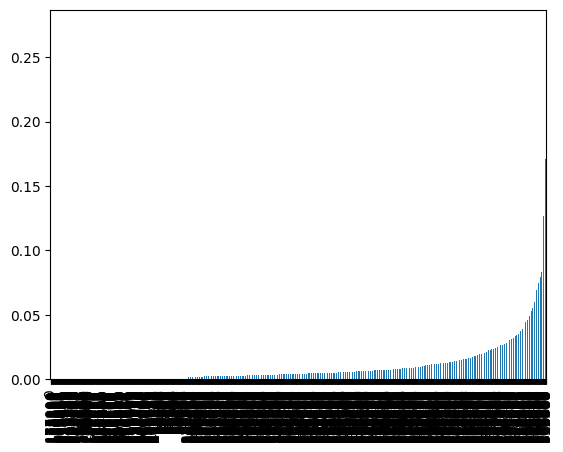

In [108]:
# From experimenting it seems like sorting by the min word count gives a better estimation of the
# complexity of the sentence, but sometimes a simple sentence will contain one very obscure word
# that unjustly shoots its value up. Taking the average word frequency often does the opposite:
# Prioritises sentences that may contain lots of simple linking words such as de and la even if
# the sentence may contain some complex words. A weighting of the two might be more indicative.
# Would have to normalise their distributions first.

import matplotlib.pyplot as plt

df['norm_min_count'] = df['min_count'] / df['min_count'].max()
df['norm_average_count'] = df['average_count'] / df['average_count'].max()

# Plot the distributions of min scores
centimated_df = df[df.index % 100 == 0].sort_values(by='norm_min_count')['norm_min_count']

#centimated_df.count()
centimated_df.plot(kind='bar')
plt.show()

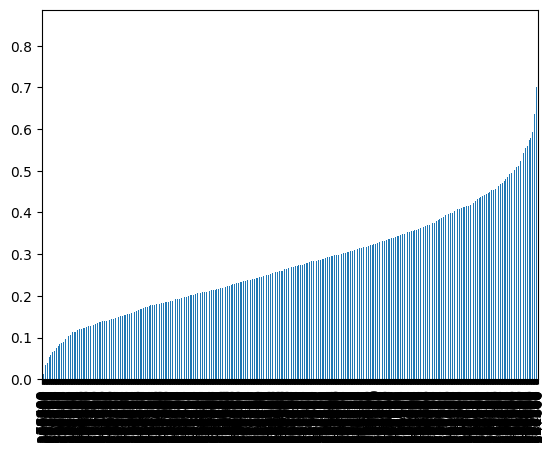

In [109]:
# Plot the distributions of min scores
centimated_df = df[df.index % 100 == 0].sort_values(by='norm_average_count')['norm_average_count']

#centimated_df.count()
centimated_df.plot(kind='bar')
plt.show()

If I remove the extreme valuesthe normalised distribution of average frequency scores is pretty linear, whereas the distribution of minimum values (The rarest word in the sentence) is logarithmic. I therefore need to apply a transformation to one to enable a weighted average to be calculated.

In [110]:
# Remove sentences whose average counts are within the top or bottom 10% and normalise so that
# highest value equal to 1 and lowest value equal to zero
bottom_threshold = df.quantile(0.1)
top_threshold = df.quantile(0.9)

df = df[
    df['norm_average_count'] >= bottom_threshold
    & df['norm_average_count'] <= top_threshold
    ]

TypeError: unsupported operand type(s) for -: 'str' and 'str'